Question 1 - LSTM Autoencoder
You are required to build an LSTM Autoencoder to detect anomalies in a time series dataset. The
dataset contains daily temperature readings from a weather station over the course of a few years.
Your task is to:
1. Load the dataset: The dataset will contain a single column temperature and a date column.
2. Preprocess the data: Normalize the temperature data and split it into training and testing
sets.
3. Build an LSTM Autoencoder:
o The encoder should reduce the input dimensions to a latent representation.
o The decoder should reconstruct the input from the latent representation.
4. Train the model: Train the autoencoder on the training data and evaluate the
reconstruction error on the test set.
5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold
for the reconstruction error, and identify days where the temperature is considered
anomalous.
6. Visualize the results: Plot the original temperature data and highlight the detected
anomalies.

1. Load the weather_data.csv - Dataset and Parse the Date column as datetime and ensure the Temperature column is numeric.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model

In [55]:
def load_data(filepath='/content/weather_data.csv'):
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

2. Exploratory Data Analysis

In [56]:
df.tail()

,date,temperature
2552,2020-12-27,10.598482
2553,2020-12-28,9.876287
2554,2020-12-29,9.265936
2555,2020-12-30,9.986115
2556,2020-12-31,8.419751


In [57]:
df.describe()

,temperature
count,2557.000000
mean,10.017472
std,0.923047
min,3.337291
25%,9.335195
50%,10.031778
75%,10.681384
max,15.587945


In [58]:
df.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


In [59]:
df.isnull().sum()

,0
date,0
temperature,0


In [73]:
def perform_eda(df):

    plt.figure(figsize=(15, 12))

    # Time Series Plot
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['temperature'])
    plt.title('Temperature Time Series')
    plt.xlabel('Date')
    plt.ylabel('Temperature')

    # Distribution Plot
    plt.subplot(3, 1, 2)
    sns.histplot(df['temperature'], bins=30, kde=True)
    plt.title('Temperature Distribution')

    # Monthly Box Plot
    plt.subplot(3, 1, 3)
    df['month'] = df.index.month
    sns.boxplot(x='month', y='temperature', data=df)
    plt.title('Monthly Temperature Distribution')

    plt.tight_layout()
    plt.show()

    # Print basic statistics
    print("\nBasic Statistics:")
    print(df['temperature'].describe())

3. Model Implementation

In [61]:
def create_sequences(data, seq_length=7):
    return np.array([data[i:i+seq_length] for i in range(len(data)-seq_length+1)])


Create the AutoEncoder

In [70]:
def build_autoencoder(seq_length=7):
    # Encoder
    inputs = Input(shape=(seq_length, 1))
    encoded = LSTM(32, activation='relu')(inputs)

    # Decoder
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = Dense(1)(decoded)

    model = Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

Train The AutoEncoder Model

In [72]:
def train_model(model, X_train, X_test):
    history = model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, X_test),
        verbose=1
    )
    return history

4. Results Analysis and Visualization

In [81]:
def analyze_results(model, df, test_data, test_sequences, scaler):
    """Analyze and visualize results"""
    # Get predictions and errors
    predictions = model.predict(test_sequences)
    mse = np.mean(np.square(test_sequences - predictions), axis=(1,2))
    threshold = np.mean(mse) + 2 * np.std(mse)
    anomalies = mse > threshold

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(test_data.index, scaler.inverse_transform(test_data), label='Original')
    anomaly_points = test_data[anomalies]
    plt.scatter(anomaly_points.index,
               scaler.inverse_transform(anomaly_points),
               color='red', label='Anomaly')
    plt.title('Temperature Data with Detected Anomalies')
    plt.legend()


    plt.subplot(2, 1, 2)
    plt.plot(mse, label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Reconstruction Error and Threshold')
    plt.legend()

    plt.tight_layout()
    plt.show()



    #Insights
    print("\nAnalysis Insights:")
    print(f"Total anomalies detected: {sum(anomalies)}")
    print(f"Anomaly percentage: {(sum(anomalies)/len(anomalies))*100:.2f}%")

    return anomalies, mse, threshold

5. Main Funtion Executions

Performing Exploratory Data Analysis...


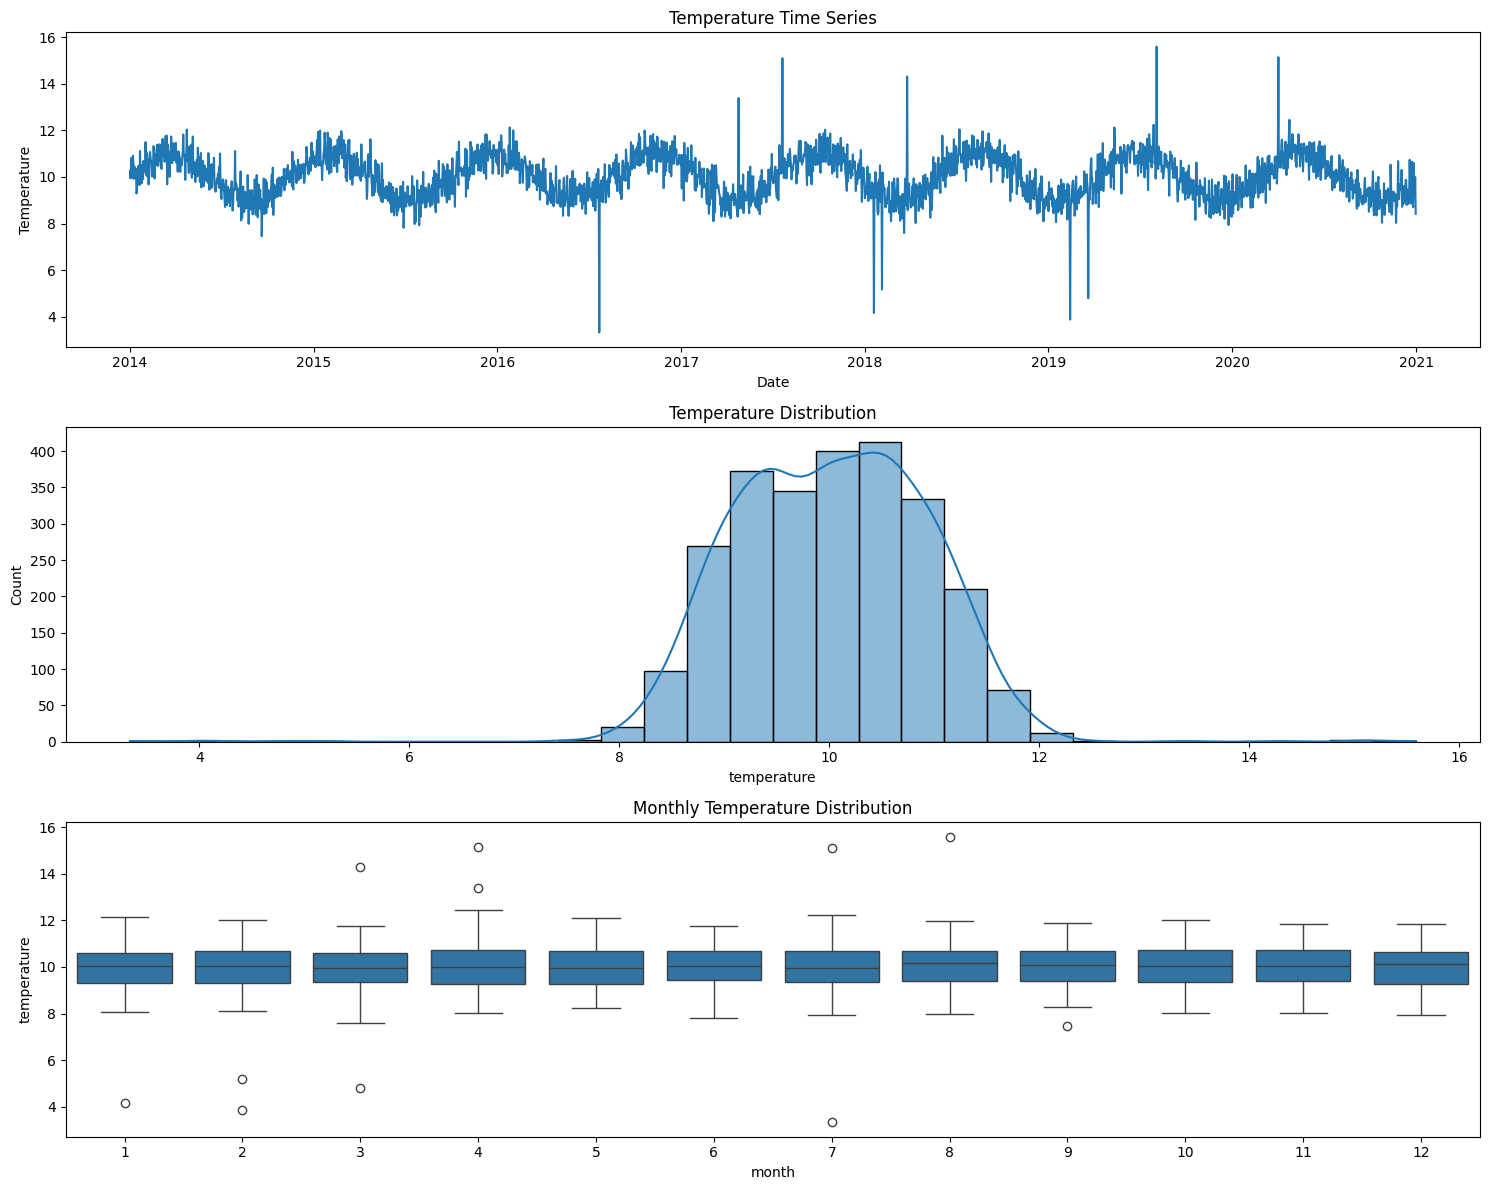


Basic Statistics:
count    2557.000000
mean       10.017472
std         0.923047
min         3.337291
25%         9.335195
50%        10.031778
75%        10.681384
max        15.587945
Name: temperature, dtype: float64

Training LSTM Autoencoder...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1744 - val_loss: 0.0212
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0149 - val_loss: 0.0049
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss

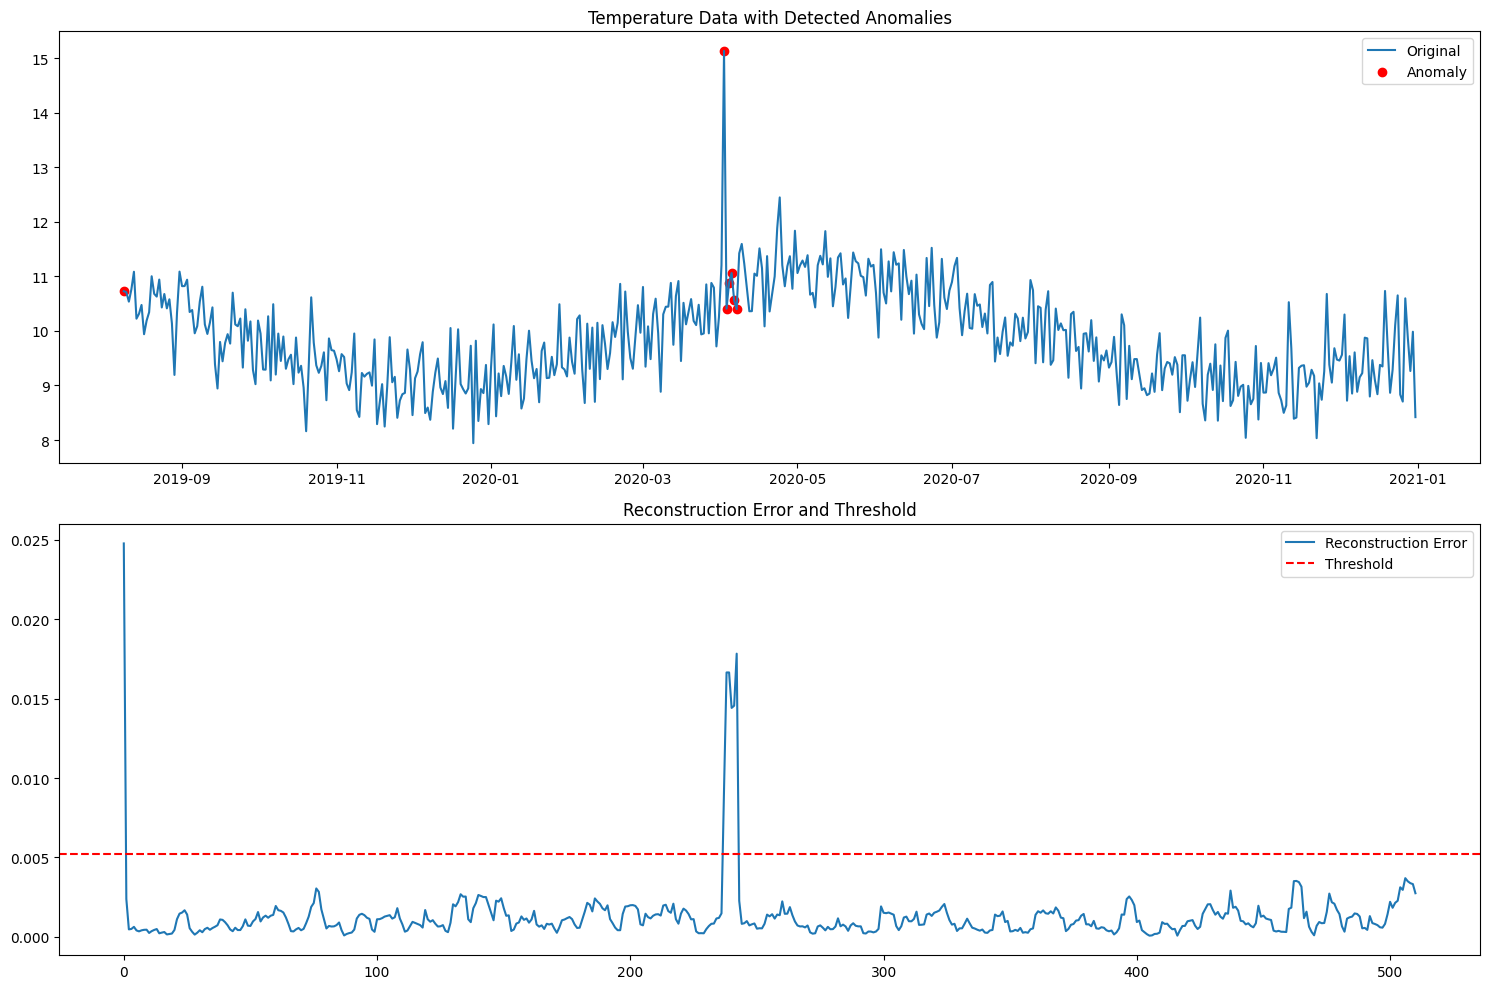


Analysis Insights:
Total anomalies detected: 7
Anomaly percentage: 1.37%


In [84]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def main():
    df = load_data()

    # 1. Perform EDA
    print("Performing Exploratory Data Analysis...")
    perform_eda(df)

    # 2. Preprocess data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['temperature']])

    # Create sequences
    seq_length = 7
    sequences = create_sequences(scaled_data)

    # Split data
    train_size = int(len(sequences) * 0.8)
    X_train = sequences[:train_size]
    X_test = sequences[train_size:]
    test_data = pd.DataFrame(
        scaled_data.flatten()[train_size + seq_length - 1:],
        index=df.index[train_size + seq_length - 1:],
        columns=['temperature']
    )

    # 3. Build and train model
    print("\nTraining LSTM Autoencoder...")
    model = build_autoencoder(seq_length)
    history = train_model(model, X_train, X_test)

    # 4. Analyze results
    print("\nAnalyzing Results...")
    anomalies, mse, threshold = analyze_results(model, df, test_data, X_test, scaler)

    return model, history, anomalies

if __name__ == "__main__":
    model, history, anomalies = main()
